## Importing Libraries

In [465]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


import warnings 
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier, 
                              GradientBoostingClassifier, HistGradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    auc,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    cohen_kappa_score,
    ConfusionMatrixDisplay
)

import scipy.stats as ss
from dython.nominal import correlation_ratio , cramers_v, associations

## Load the dataset

Notes to consider:

- The data is not in CSV format, but pandas read_csv can read it
- The data is delimited with a comma
- The data doesn't have a columns row (header), so we set the header parameter to None and also give the column names in the order we have from the Data Description
- The first row in the test data is incorrect so we skip it 

In [611]:
cols = ['Age', 'Workclass', 'Fnlwgt', 'Education','EducationNum', 'MaritalStatus', 'Occupation', 'Relationship', 'Race',
       'Sex', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek', 'NativeCountry', 'Income'] 
df_train = pd.read_csv("Data/adult.data", delimiter=",", header=None, names=cols, index_col=False)
df_test = pd.read_csv("Data/adult.test", delimiter=",", header=None, names=cols, index_col=False, skiprows=1)

In [410]:
#Sanity Check do we have 48842 as specified in data source
df_train.shape[0] + df_test.shape[0]

48842

### Initial look at the data

We'll only explore the training data to avoid any data leakage and to prevent developing any potential bais from encountering the test data. 

First points regarding the initial look
- Data is loaded correctly with the values in place
- For the CapitalGain and CapitalLoss columns it seems like they are mostly 0 and we'll get a skewed distribution (will confirm if true later) 
- For our target variable Income it seems like most records are <=50k
- HoursPerWeek seems like it is mostly 40 hours (usual 8 hrs 5 day weeks)

In [411]:
df_train.head()

Age          Workclass  Fnlwgt   Education  EducationNum  \
0   39          State-gov   77516   Bachelors            13   
1   50   Self-emp-not-inc   83311   Bachelors            13   
2   38            Private  215646     HS-grad             9   
3   53            Private  234721        11th             7   
4   28            Private  338409   Bachelors            13   

         MaritalStatus          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   CapitalGain  CapitalLoss  HoursPerWeek   NativeCountry  Income  
0         2174            0            40   United-States   <=50K  
1            0            0            13   United-States   <=50K  
2            0            0            40   United-States   <=50K  
3            0            0            40   United-States   <=50K  
4            0            0            40            Cuba   <=50K

Looking at only the first 5 rows to check if data is loaded correctly

In [412]:
df_test.head()

Age   Workclass  Fnlwgt      Education  EducationNum        MaritalStatus  \
0   25     Private  226802           11th             7        Never-married   
1   38     Private   89814        HS-grad             9   Married-civ-spouse   
2   28   Local-gov  336951     Assoc-acdm            12   Married-civ-spouse   
3   44     Private  160323   Some-college            10   Married-civ-spouse   
4   18           ?  103497   Some-college            10        Never-married   

           Occupation Relationship    Race      Sex  CapitalGain  CapitalLoss  \
0   Machine-op-inspct    Own-child   Black     Male            0            0   
1     Farming-fishing      Husband   White     Male            0            0   
2     Protective-serv      Husband   White     Male            0            0   
3   Machine-op-inspct      Husband   Black     Male         7688            0   
4                   ?    Own-child   White   Female            0            0   

   HoursPerWeek   NativeCountry   Income  
0            40   United-States   <=50K.  
1            50   United-States   <=50K.  
2            40   United-States    >50K.  
3            40   United-States    >50K.  
4            30   United-States   <=50K.

In [413]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            32561 non-null  int64 
 1   Workclass      32561 non-null  object
 2   Fnlwgt         32561 non-null  int64 
 3   Education      32561 non-null  object
 4   EducationNum   32561 non-null  int64 
 5   MaritalStatus  32561 non-null  object
 6   Occupation     32561 non-null  object
 7   Relationship   32561 non-null  object
 8   Race           32561 non-null  object
 9   Sex            32561 non-null  object
 10  CapitalGain    32561 non-null  int64 
 11  CapitalLoss    32561 non-null  int64 
 12  HoursPerWeek   32561 non-null  int64 
 13  NativeCountry  32561 non-null  object
 14  Income         32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


The data types are correctly inferred. We see no missing values but accordinfg to the data source there are missing values we'll hand these next. Looking at the data the missing values are denoted by a question mark

In [414]:
for col in cols:
    missing = df_train.loc[df_train[col] == '?',].shape[0]
    print(f'{col}, number missing = {missing}')

Age, number missing = 0
Workclass, number missing = 0
Fnlwgt, number missing = 0
Education, number missing = 0
EducationNum, number missing = 0
MaritalStatus, number missing = 0
Occupation, number missing = 0
Relationship, number missing = 0
Race, number missing = 0
Sex, number missing = 0
CapitalGain, number missing = 0
CapitalLoss, number missing = 0
HoursPerWeek, number missing = 0
NativeCountry, number missing = 0
Income, number missing = 0


We have no missing data, still there is something wrong let's look at a columns unique values

In [415]:
df_train['Workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

There is a trailing space in all the values let's remove that

In [416]:
categorical_cols = df_train.select_dtypes(include=['O']).columns
df_train[categorical_cols] = df_train[categorical_cols].apply(lambda x: x.str.strip())

In [417]:
for col in cols:
    missing = df_train.loc[df_train[col] == '?',].shape[0]
    print(f'{col}, number missing = {missing}')

Age, number missing = 0
Workclass, number missing = 1836
Fnlwgt, number missing = 0
Education, number missing = 0
EducationNum, number missing = 0
MaritalStatus, number missing = 0
Occupation, number missing = 1843
Relationship, number missing = 0
Race, number missing = 0
Sex, number missing = 0
CapitalGain, number missing = 0
CapitalLoss, number missing = 0
HoursPerWeek, number missing = 0
NativeCountry, number missing = 583
Income, number missing = 0


Now we get the missing values correctly but we'll replace the question mark with nan

In [418]:
df_train[df_train == '?'] = np.nan

In [419]:
df_train.isna().sum()

Age                 0
Workclass        1836
Fnlwgt              0
Education           0
EducationNum        0
MaritalStatus       0
Occupation       1843
Relationship        0
Race                0
Sex                 0
CapitalGain         0
CapitalLoss         0
HoursPerWeek        0
NativeCountry     583
Income              0
dtype: int64

In [420]:
df_train.describe()

Age        Fnlwgt  EducationNum   CapitalGain   CapitalLoss  \
count  32561.000000  3.256100e+04  32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05     10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05      2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04      1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05      9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05     10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05     12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06     16.000000  99999.000000   4356.000000   

       HoursPerWeek  
count  32561.000000  
mean      40.437456  
std       12.347429  
min        1.000000  
25%       40.000000  
50%       40.000000  
75%       45.000000  
max       99.000000

In [421]:
describe_df_num = df_train.describe()
education_dict = df_train.groupby('EducationNum')['Education'].unique().apply(lambda x: x[0]).to_dict()

In [422]:
display(Markdown
        (f"Describe gives us a nice data summary. The mean age is {round(describe_df_num.loc['mean', 'Age'],1)} \
        with the youngest being {round(describe_df_num.loc['min','Age'],0)} and oldest {round(describe_df_num.loc['max','Age'],0)}."))

display(Markdown(f"Average Capital Gain is {round(describe_df_num.loc['mean','CapitalGain'])}"))
display(Markdown(f"Average Capital Loss is {round(describe_df_num.loc['mean','CapitalLoss'])}"))
display(Markdown(f"Average Hours worked per week is {round(describe_df_num.loc['mean','HoursPerWeek'])} and maximum being \
{describe_df_num.loc['max', 'HoursPerWeek']}"))

Describe gives us a nice data summary. The mean age is 38.6         with the youngest being 17.0 and oldest 90.0.

Average Capital Gain is 1078

Average Capital Loss is 87

Average Hours worked per week is 40 and maximum being 99.0

In [423]:
df_train.describe(include=['O'])

Workclass Education       MaritalStatus      Occupation Relationship  \
count      30725     32561               32561           30718        32561   
unique         8        16                   7              14            6   
top      Private   HS-grad  Married-civ-spouse  Prof-specialty      Husband   
freq       22696     10501               14976            4140        13193   

         Race    Sex  NativeCountry Income  
count   32561  32561          31978  32561  
unique      5      2             41      2  
top     White   Male  United-States  <=50K  
freq    27816  21790          29170  24720

Describe for categorical variables is easier to interpret we only get 3 useful statistics. We see the cardinality of each variable with NativeCountry having the highest cardinality and Income and Sex the lowest (2 values). The most achieved Education is HS-grad. Most workclass is Private. Most people surveyed are white males in the USA with an income less than 50K 

## Exploratory Data Analysis

- The aim here is to explore the data further to discover associations (if any)
- Figure out how the variables are distributed and how they are related to our target variable (Income)
- Aid the exploration with well labeled visuals 
- Assesss and determine how to best deal with the missing data
- Assess and determine if we can add or remove some features/variables (feature engineering; can be a different phase itself)

### Feature Analysis

In [424]:
income_plot = df_train['Income'].value_counts().reset_index().rename(columns={'index':'Income', 'Income':'Count'})
income_plot['Percentage'] = "<b>" + ((income_plot.Count/income_plot.Count.sum())*100).round(2).astype(str) + "% </b>"
fig_income = px.bar(income_plot, y='Income', x='Count', text='Percentage', orientation='h')
fig_income = fig_income.update_traces(textposition='outside')
fig_income.update_layout(title = "Distribution of Income Classes")
fig_income.update_xaxes(range=[0, income_plot.Count.max() +2000])

We see this is an unbalanced dataset with most people having an income less than 50k as mentioned above, we'll deal with that in the modelling phase

In [425]:
age_distribution = px.histogram(df_train, x= df_train.Age, nbins=100,
                               title='Histogram of Age',opacity=0.8,color_discrete_sequence=['indianred'])


age_distribution.show()

Age has a right-skewed distribution with a bump for 90 year old citizens. What would also be cool to see is the same distribution segmented by the Income class

In [426]:
age_distribution_inc = px.histogram(df_train, x= df_train.Age, nbins=100,
                               title='Histogram of Age colored by Income',opacity=0.8,color="Income")


age_distribution_inc.show()

As the data is imbalanaced we expected to see that most people will have an income of <=50k but that decreases notably as people get older

In [427]:
wrkclass = df_train.Workclass.value_counts().reset_index().rename(columns={"index": "Work Class", "Workclass": "Count"})
wrkclass['Percentage'] = "<b>" + ((wrkclass.Count/wrkclass.Count.sum())*100).round(2).astype(str) + "% </b>"
fig_wrkclass = px.bar(wrkclass, y='Work Class', x='Count', text='Percentage', orientation='h')
fig_wrkclass = fig_wrkclass.update_traces(textposition='outside')
fig_wrkclass.update_layout(title = "Distribution of Work Classes")
fig_wrkclass.update_xaxes(range=[0, wrkclass.Count.max() +2000])

Most of the people in the survey belong to the Private sector. But how does that affect the Income (if there is any effect)

In [428]:
wrkclass_inc = df_train.groupby(['Workclass', 'Income']).size().unstack().reset_index()
wrkclass_inc = wrkclass_inc.melt(id_vars="Workclass", value_vars=["<=50K", ">50K"])
wrkclass_inc['Percentage'] = "<b>" + ((wrkclass_inc.value/wrkclass_inc.value.sum())*100).round(2).astype(str) + "% </b>"
wrkclass_inc.loc[wrkclass_inc.value.isna(), 'Percentage'] = ''

fig_wrkclass_inc = px.bar(wrkclass_inc, y="Workclass", x="value", color="Income", orientation='h',text='Percentage', 
                          barmode='group', opacity=0.6, color_discrete_sequence=px.colors.diverging.Portland)
fig_wrkclass_inc = fig_wrkclass_inc.update_traces(textposition='outside')
fig_wrkclass_inc.update_layout(title = "Distribution of Work Classes by Income")
fig_wrkclass_inc.update_xaxes(range=[0, wrkclass_inc.value.max() +2000])

For those who without pay of course have an income value of <=50K. 7 people who never-worked have an income of >50K
The private sector that contains most of the people in the survey also has over 3 times the number of employees who earn less than 50k compared to their counterparts who earn more than 50k. The only workclass that has people who earn >50k more than people who earn <=50k is the Self employment, this is intuituve as most people here start their own businesses and this helps in acheiving a greater income.

In [429]:
educ = df_train.Education.value_counts().reset_index().rename(columns={"index": "Education", "Education": "Count"})
educ['Percentage'] = "<b>" + ((educ.Count/educ.Count.sum())*100).round(2).astype(str) + "% </b>"
fig_educ = px.bar(educ, y='Education', x='Count', text='Percentage', orientation='h',color_discrete_sequence=px.colors.sequential.Agsunset_r)
fig_educ = fig_educ.update_traces(textposition='outside')
fig_educ.update_layout(title = "Distribution of Education")
fig_educ.update_xaxes(range=[0, educ.Count.max() +2000])

In [430]:
edu_inc = df_train.groupby(['Education', 'Income']).size().unstack().reset_index()
edu_inc = edu_inc.melt(id_vars="Education", value_vars=["<=50K", ">50K"])
edu_inc['Percentage'] = "<b>" + ((edu_inc.value/edu_inc.value.sum())*100).round(2).astype(str) + "% </b>"
edu_inc.loc[edu_inc.value.isna(), 'Percentage'] = ''

fig_edu_inc = px.bar(edu_inc, y="Education", x="value", color="Income", orientation='h',text='Percentage', 
                          barmode='group', opacity=0.6, color_discrete_sequence=px.colors.diverging.Portland)
fig_edu_inc = fig_edu_inc.update_traces(textposition='outside')
fig_edu_inc.update_layout(title = "Distribution of Education by Income")
fig_edu_inc.update_xaxes(range=[0, edu_inc.value.max() + 500])

There isn't much information here, as most people in the survey have acheived a High school degree, it is also the education group with the most high earners. What is interesting is that the three education groups with more high earners than lower earners are the Masters, Doctorate and Prof-school as expected. 

For Assoc-acad and Assoc-voc education groups there are a few people who earn more than 50K.

In [431]:
maritial = df_train.MaritalStatus.value_counts().reset_index().rename(columns={"index": "Marital Status", "MaritalStatus": "Count"})
maritial['Percentage'] = "<b>" + ((maritial.Count/maritial.Count.sum())*100).round(2).astype(str) + "% </b>"
fig_maritial = px.bar(maritial, y='Marital Status', x='Count', text='Percentage', orientation='h',color_discrete_sequence=px.colors.sequential.Agsunset_r)
fig_maritial = fig_maritial.update_traces(textposition='outside')
fig_maritial.update_layout(title = "Distribution of Marital Status")
fig_maritial.update_xaxes(range=[0, maritial.Count.max() +2000])

In [432]:
martial_inc = df_train.groupby(['MaritalStatus', 'Income']).size().unstack().reset_index()
martial_inc = martial_inc.melt(id_vars="MaritalStatus", value_vars=["<=50K", ">50K"])
martial_inc['Percentage'] = "<b>" + ((martial_inc.value/martial_inc.value.sum())*100).round(2).astype(str) + "% </b>"
martial_inc.loc[martial_inc.value.isna(), 'Percentage'] = ''

fig_edu_inc = px.bar(martial_inc, y="MaritalStatus", x="value", color="Income", orientation='h',text='Percentage', 
                          barmode='group', opacity=0.6, color_discrete_sequence=px.colors.diverging.Portland)
fig_edu_inc = fig_edu_inc.update_traces(textposition='outside')
fig_edu_inc.update_layout(title = "Distribution of Marital Status by Income")
fig_edu_inc.update_xaxes(range=[0, martial_inc.value.max() + 1000])

Married-civ-spouse is the only category which has comparable number of people belonging to both categories. It is also the highest earning group, but again it is also the most present in the dataset. Never-married comes straight after as the next most present but they are mostly earning <=50k. This may be due to the fact that they are relatively younger so they have less experience or there can be a range of other factors.

In [433]:
martial_inc_wrk = df_train.groupby(['MaritalStatus', 'Workclass']).size().unstack().reset_index()
martial_inc_wrk = martial_inc_wrk.melt(id_vars="MaritalStatus", value_vars=martial_inc_wrk.columns)

martial_inc_wrk['Percentage'] = "<b>" + ((martial_inc_wrk.value/martial_inc_wrk.value.sum())*100).round(2).astype(str) + "% </b>"
martial_inc_wrk.loc[martial_inc_wrk.value.isna(), 'Percentage'] = ''

fig_martial_wrk = px.bar(martial_inc_wrk, y="MaritalStatus", x="value", color="Workclass", orientation='h',text='Percentage', 
                          barmode='group', opacity=0.6, color_discrete_sequence=px.colors.diverging.Portland)
fig_martial_wrk = fig_martial_wrk.update_traces(textposition='outside')
fig_martial_wrk.update_layout(title = "Distribution of Marital Status by Workclass")
fig_martial_wrk.update_xaxes(range=[0, martial_inc_wrk.value.max() + 500])

Again in all the marital statuses, private sector is where most people work. It usually is the case with an overwhelming majority.
Except for people with a married civilian spouse where local-govt and self-employed-not-inc had more than 1600 and 1000 entries respectively with private sectors were at 9.7k.

In [434]:
martial_inc_edu = df_train.groupby(['MaritalStatus', 'Education']).size().unstack().reset_index()
martial_inc_edu = martial_inc_edu.melt(id_vars="MaritalStatus", value_vars=martial_inc_edu.columns)
martial_inc_edu['Percentage'] = "<b>" + ((martial_inc_edu.value/martial_inc_edu.value.sum())*100).round(2).astype(str) + "% </b>"
martial_inc_edu.loc[martial_inc_edu.value.isna(), 'Percentage'] = ''
fig_martial_edu = px.bar(martial_inc_edu, y="MaritalStatus", x="value", color="Education", orientation='h',text='Percentage', 
                          barmode='group', opacity=0.6, color_discrete_sequence=px.colors.diverging.Portland)
fig_martial_edu = fig_martial_edu.update_traces(textposition='outside')
fig_martial_edu.update_layout(title = "Distribution of Marital Status by Education")
fig_martial_edu.update_xaxes(range=[0, martial_inc_edu.value.max() + 100])

Note: We can zoom with plotly as the figure can be a bit harder to read.

Most people who did their masters, bachelors or went to some collage tend to have civilian spouses. Bachelors and people who went to some collage are also amongst those who were not married.
This may be because of the number of people with bachelors, High school degree and people going to some collage are higher than most other education groups. However, a lot of the people who did their masters did prefer civilian spouses.

In [435]:
occupation = df_train.Occupation.value_counts().reset_index().rename(columns={"index": "Occupation", "Occupation": "Count"})
occupation['Percentage'] = "<b>" + ((occupation.Count/occupation.Count.sum())*100).round(2).astype(str) + "% </b>"
fig_occupation = px.bar(occupation, y='Occupation', x='Count', text='Percentage', orientation='h',color_discrete_sequence=px.colors.sequential.Agsunset_r)
fig_occupation = fig_occupation.update_traces(textposition='outside')
fig_occupation.update_layout(title = "Distribution of Occupations")
fig_occupation.update_xaxes(range=[0, occupation.Count.max() +2000])

Occupation seems like the most uniform distribution compared to other categorical variables. 

In [436]:
occ_inc = df_train.groupby(['Occupation', 'Income']).size().unstack().reset_index()
occ_inc = occ_inc.melt(id_vars="Occupation", value_vars=["<=50K", ">50K"])
occ_inc['Percentage'] = "<b>" + ((occ_inc.value/occ_inc.value.sum())*100).round(2).astype(str) + "% </b>"
occ_inc.loc[occ_inc.value.isna(), 'Percentage'] = ''

fig_occ_inc = px.bar(occ_inc, y="Occupation", x="value", color="Income", orientation='h',text='Percentage', 
                          barmode='group', opacity=0.6, color_discrete_sequence=px.colors.diverging.Portland)
fig_occ_inc = fig_occ_inc.update_traces(textposition='outside')
fig_occ_inc.update_layout(title = "Distribution of Occupations by Income")
fig_occ_inc.update_xaxes(range=[0, occ_inc.value.max() + 1000])

Around 27% of the people working in Sales earn more than 50K. 
The Exec-managerial occupation is the highest earning occupation followed very closly by the Prof-specialty.
There's close to 33% probablity for an adult in Prof-specialty to earn more than 50K.
People working in Farming-fishing, Machine-op-inspect, Other-service, Adm-clerical, Transport-moving are less likely to earn more than 50K.

In [437]:
relationship = df_train.Relationship.value_counts().reset_index().rename(columns={"index": "Relationship", "Relationship": "Count"})
relationship['Percentage'] = "<b>" + ((relationship.Count/relationship.Count.sum())*100).round(2).astype(str) + "% </b>"
fig_relationship = px.bar(relationship, y='Relationship', x='Count', text='Percentage', orientation='h',color_discrete_sequence=px.colors.sequential.Agsunset_r)
fig_relationship = fig_relationship.update_traces(textposition='outside')
fig_relationship.update_layout(title = "Distribution of Relationship")
fig_relationship.update_xaxes(range=[0, relationship.Count.max() +2000])

In [438]:
rel_inc = df_train.groupby(['Relationship', 'Income']).size().unstack().reset_index()
rel_inc = rel_inc.melt(id_vars="Relationship", value_vars=["<=50K", ">50K"])
rel_inc['Percentage'] = "<b>" + ((rel_inc.value/rel_inc.value.sum())*100).round(2).astype(str) + "% </b>"
rel_inc.loc[rel_inc.value.isna(), 'Percentage'] = ''

fig_rel_inc = px.bar(rel_inc, y="Relationship", x="value", color="Income", orientation='h',text='Percentage', 
                          barmode='group', opacity=0.6, color_discrete_sequence=px.colors.diverging.Portland)
fig_rel_inc = fig_rel_inc.update_traces(textposition='outside')
fig_rel_inc.update_layout(title = "Distribution of Occupations by Income")
fig_rel_inc.update_xaxes(range=[0, rel_inc.value.max() + 1000])

For Husbands, although significant, there is less possibility of them to earn more than 50K.
There are just a handful of Unmarried people earning more than 50K.
Wives are equally likely to earn more than 50K.

In [439]:
race = df_train.Race.value_counts().reset_index().rename(columns={"index": "Race", "Race": "Count"})
race['Percentage'] = "<b>" + ((race.Count/race.Count.sum())*100).round(2).astype(str) + "% </b>"
fig_race = px.bar(race, y='Race', x='Count', text='Percentage', orientation='h',color_discrete_sequence=px.colors.sequential.Agsunset_r)
fig_race = fig_race.update_traces(textposition='outside')
fig_race.update_layout(title = "Distribution of Race")
fig_race.update_xaxes(range=[0, race.Count.max() +2000])

This is a white dominated dataset.

In [440]:
race_inc = df_train.groupby(['Race', 'Income']).size().unstack().reset_index()
race_inc = race_inc.melt(id_vars="Race", value_vars=["<=50K", ">50K"])
race_inc['Percentage'] = "<b>" + ((race_inc.value/race_inc.value.sum())*100).round(2).astype(str) + "% </b>"
race_inc.loc[race_inc.value.isna(), 'Percentage'] = ''

fig_race_inc = px.bar(race_inc, y="Race", x="value", color="Income", orientation='h',text='Percentage', 
                          barmode='group', opacity=0.6, color_discrete_sequence=px.colors.diverging.Portland)
fig_race_inc = fig_race_inc.update_traces(textposition='outside')
fig_race_inc.update_layout(title = "Distribution of Race by Income")
fig_race_inc.update_xaxes(range=[0, race_inc.value.max() + 2000])

One point to note here is that, except Whites there are very few people of different races. Beacause of this one may fail to notice the exact percentage and relationship with peoples income.

In [441]:
sex = df_train.Sex.value_counts().reset_index().rename(columns={"index": "Sex", "Sex": "Count"})
sex['Percentage'] = "<b>" + ((sex.Count/sex.Count.sum())*100).round(2).astype(str) + "% </b>"
fig_sex = px.bar(sex, y='Sex', x='Count', text='Percentage', orientation='h',color_discrete_sequence=px.colors.sequential.Agsunset_r)
fig_sex = fig_sex.update_traces(textposition='outside')
fig_sex.update_layout(title = "Distribution of Sex")
fig_sex.update_xaxes(range=[0, sex.Count.max() +2000])

In [442]:
sex_inc = df_train.groupby(['Sex', 'Income']).size().unstack().reset_index()
sex_inc = sex_inc.melt(id_vars="Sex", value_vars=["<=50K", ">50K"])
sex_inc['Percentage'] = "<b>" + ((sex_inc.value/sex_inc.value.sum())*100).round(2).astype(str) + "% </b>"
sex_inc.loc[sex_inc.value.isna(), 'Percentage'] = ''

fig_sex_inc = px.bar(sex_inc, y="Sex", x="value", color="Income", orientation='h',text='Percentage', 
                          barmode='group', opacity=0.6, color_discrete_sequence=px.colors.diverging.Portland)
fig_sex_inc = fig_sex_inc.update_traces(textposition='outside')
fig_sex_inc.update_layout(title = "Distribution of Race by Income")
fig_sex_inc.update_xaxes(range=[0, sex_inc.value.max() + 2000])

There is a significant gap in the income between males and females.

For Females, there are less than 4% earning more than 50K.
In case of Males there are 20% of them earning more than 50K.

In [443]:
country = df_train.NativeCountry.value_counts().reset_index().rename(columns={"index": "Native Country", "NativeCountry": "Count"})
country['Percentage'] = "<b>" + ((country.Count/country.Count.sum())*100).round(2).astype(str) + "% </b>"
fig_country = px.bar(country, y='Native Country', x='Count', text='Percentage', orientation='h',color_discrete_sequence=px.colors.sequential.Agsunset_r)
fig_country = fig_country.update_traces(textposition='outside')
fig_country.update_layout(title = "Distribution of Native Country", height = 800)
fig_country.update_xaxes(range=[0, country.Count.max() +2500])

Data is mostly for the US as this is US-Consensus data

In [444]:
country_inc = df_train.groupby(['NativeCountry', 'Income']).size().unstack().reset_index()
country_inc = country_inc.melt(id_vars="NativeCountry", value_vars=["<=50K", ">50K"])
country_inc['Percentage'] = "<b>" + ((country_inc.value/country_inc.value.sum())*100).round(2).astype(str) + "% </b>"
country_inc.loc[country_inc.value.isna(), 'Percentage'] = ''

fig_country_inc = px.bar(country_inc, y="NativeCountry", x="value", color="Income", orientation='h',text='Percentage', 
                          barmode='group', opacity=0.6, color_discrete_sequence=px.colors.diverging.Portland)
fig_country_inc = fig_country_inc.update_traces(textposition='outside')
fig_country_inc.update_layout(title = "Distribution of Native Country by Income")
fig_country_inc.update_xaxes(range=[0, country_inc.value.max() + 2000])

In [445]:
capital = df_train.melt(value_vars=['CapitalLoss', 'CapitalGain'])
px.histogram(capital, x='value', color='variable', opacity =0.5, nbins=60)

In [446]:
df_train["CapitalGain"].quantile(np.round(np.arange(0.00, 1.01, 0.01), 2)).loc[0.90:]

0.90        0.0
0.91        0.0
0.92     1458.2
0.93     2885.0
0.94     3818.0
0.95     5013.0
0.96     7298.0
0.97     7688.0
0.98    14084.0
0.99    15024.0
1.00    99999.0
Name: CapitalGain, dtype: float64

In [447]:
df_train["CapitalLoss"].quantile(np.round(np.arange(0.00, 1.01, 0.01), 2)).loc[0.90:]

0.90       0.0
0.91       0.0
0.92       0.0
0.93       0.0
0.94       0.0
0.95       0.0
0.96    1590.0
0.97    1848.0
0.98    1902.0
0.99    1980.0
1.00    4356.0
Name: CapitalLoss, dtype: float64

In [448]:
px.histogram(df_train, x= df_train.HoursPerWeek, nbins=100)

### Association Analysis

In [449]:
corr = df_train.corr()
corr_fig = px.imshow(corr, color_continuous_scale= px.colors.sequential.Aggrnyl_r)
for i,r in enumerate(corr.values):
    for k,c in enumerate(r):
        if pd.isna(c):
            c = 'No Data Point'
            corr_fig.add_annotation(x=k,y=i,
                               text=f'<b>{c}</b>',
                               showarrow=False,
                               font = dict(color='black'))
        else:
            corr_fig.add_annotation(x=k,y=i,
                               text=f'<b>{c:.2f}</b>',
                               showarrow=False,
                               font = dict(color='black'))
corr_fig = corr_fig.update_layout(title = 'Correlation Between Numerical Varibles')

corr_fig.show()

We don't see any signifant correlation between the numerical variables. Maybe we do between categorical and numerical variables (we'll use the correlation ration (Eta η) for that https://en.wikipedia.org/wiki/Correlation_ratio)

[]

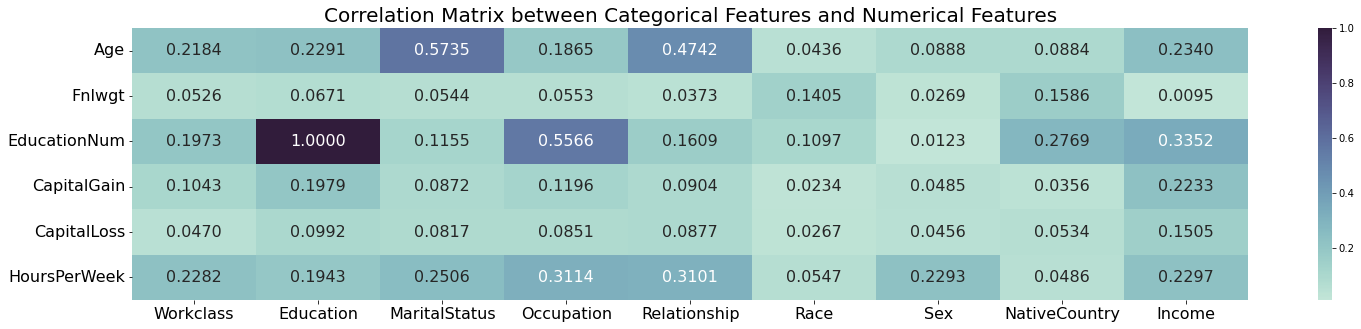

In [450]:
correlation_mixed = pd.DataFrame(index=df_train.select_dtypes(exclude=['O']).columns,columns=categorical_cols)

for i,col_cat in enumerate(categorical_cols):
    for j, col_num in enumerate(correlation_mixed.index):
        cor = float(correlation_ratio(df_train[col_cat], df_train[col_num]))
        correlation_mixed.loc[col_num,categorical_cols[i]] = cor
plt.figure(figsize=(25,5))
g = sns.heatmap(correlation_mixed.astype(float),annot=True,fmt='.4f', annot_kws={"fontsize":16},cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
g.set_yticklabels(correlation_mixed.index, fontsize = 16)
g.set_xticklabels(categorical_cols, fontsize = 16)
_ = plt.title("Correlation Matrix between Categorical Features and Numerical Features", fontdict={'fontsize':20})
plt.plot()

As expected we see a perfect correlation between Education and its numerical representaion EducationNum. We see a fairly strong (for eta η) association between Age and MartialStatus. EducationNum and Occupation. And we see weak association between Relationship and Age, Occupation and HoursPerWeek, Relationship and HoursPerWeek and Income and EducationNum.

In [451]:
scatter_age = px.scatter(df_train, x = "Income", y="Age")
scatter_age.update_traces(marker_size = 3)
scatter_age.show()

In [452]:
scatter_edu = px.scatter(df_train, x = "Income", y="EducationNum")
scatter_edu.update_traces(marker_size = 3)
scatter_edu.show()

[]

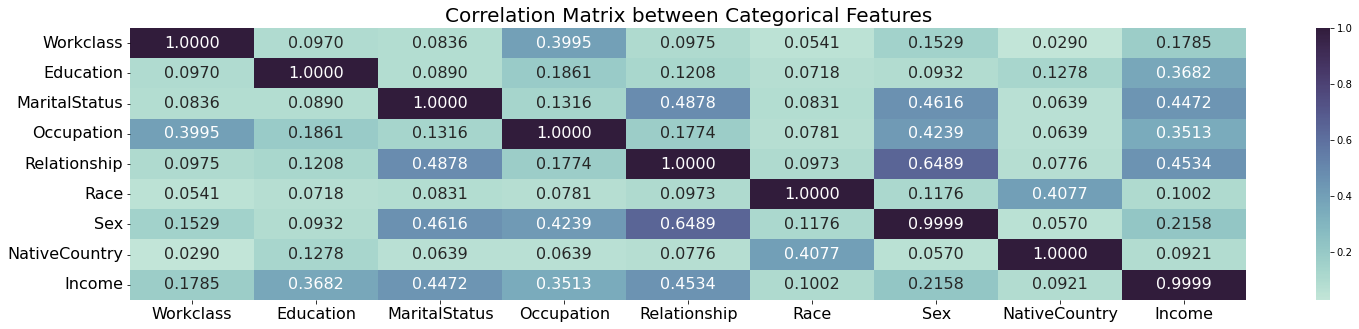

In [453]:
correlation_nom = pd.DataFrame(index=df_train.select_dtypes(include=['O']).columns,columns=categorical_cols)

for i,col_cat in enumerate(categorical_cols):
    for j, col_cat2 in enumerate(correlation_nom.index):
        cor = float(cramers_v(df_train[col_cat], df_train[col_cat2]))
        correlation_nom.loc[col_cat2,categorical_cols[i]] = cor
plt.figure(figsize=(25,5))
g = sns.heatmap(correlation_nom.astype(float),annot=True,fmt='.4f', annot_kws={"fontsize":16},cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
g.set_yticklabels(correlation_nom.index, fontsize = 16)
g.set_xticklabels(categorical_cols, fontsize = 16)
_ = plt.title("Correlation Matrix between Categorical Features", fontdict={'fontsize':20})
plt.plot()

We see a high association between Relationship and Sex, Relationship and Martial Status, Income and Relationship, Martial Status and Martial Status and Sex. All seem reasonable 

We'll see if changing the target variable to a binary numerical changes any of our findings

[]

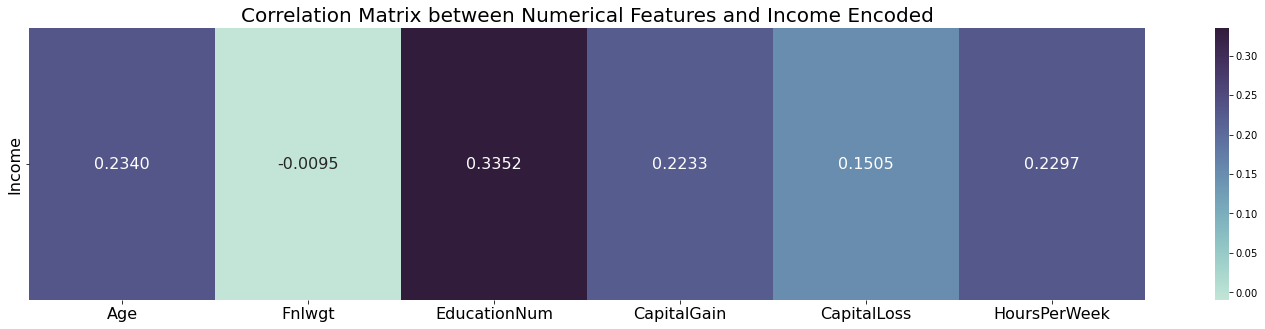

In [454]:
correlation_inc = pd.DataFrame(index=['Income'],columns=df_train.select_dtypes(exclude=['O']).columns)

for i,col_num in enumerate(correlation_inc.columns):
    cor = ss.pointbiserialr(df_train.Income.replace({df_train.Income.unique()[0]: 0, df_train.Income.unique()[1]: 1}), df_train[col_num])[0]
    correlation_inc.loc[:,correlation_inc.columns[i]] = cor
    
plt.figure(figsize=(25,5))
g = sns.heatmap(correlation_inc.astype(float),annot=True,fmt='.4f', annot_kws={"fontsize":16},cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
g.set_yticklabels(correlation_inc.index, fontsize = 16)
g.set_xticklabels(correlation_inc.columns, fontsize = 16)
_ = plt.title("Correlation Matrix between Numerical Features and Income Encoded", fontdict={'fontsize':20})
plt.plot()

We see no changes so we'll encode our target variable

In [455]:
df_train['Income'] = df_train.Income.replace({df_train.Income.unique()[0]: 0, df_train.Income.unique()[1]: 1})

### Deaing with missing values, encoding, feature engineering and model selection with hyperparamter tuning

As education and education num basically convey the same information we'll drop the education num variable. We'll also drop the Fnlwgt as it also doesn't portray that much information it just assign a weight to the record according to the data source

In [456]:
df_train.drop('EducationNum', axis=1, inplace=True)
df_train.drop('Fnlwgt', axis=1, inplace=True)

<AxesSubplot:>

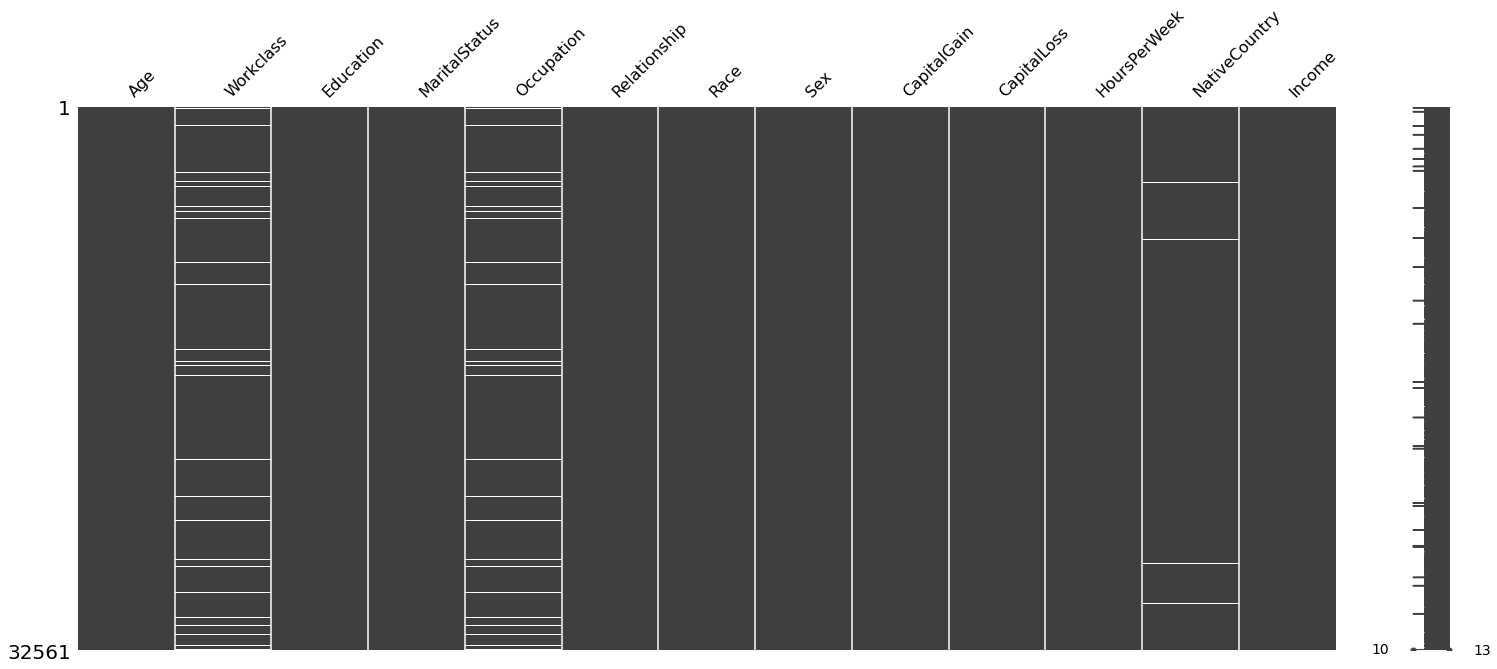

In [457]:
msno.matrix(df_train)

<AxesSubplot:>

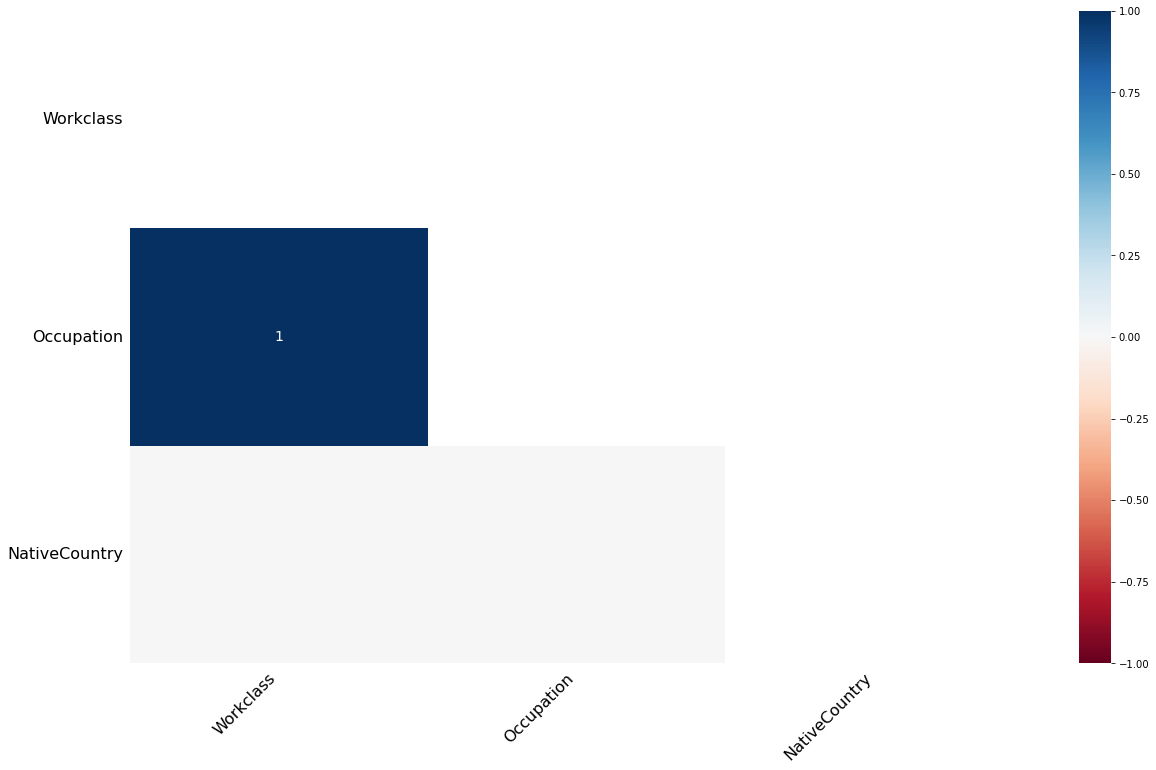

In [458]:
msno.heatmap(df_train)

In [459]:
df_train.query("Occupation.isna()")[['Occupation','Workclass']]

Occupation Workclass
27           NaN       NaN
61           NaN       NaN
69           NaN       NaN
77           NaN       NaN
106          NaN       NaN
...          ...       ...
32530        NaN       NaN
32531        NaN       NaN
32539        NaN       NaN
32541        NaN       NaN
32542        NaN       NaN

[1843 rows x 2 columns]

In [460]:
df_train.isna().mean()[df_train.isna().mean() > 0]

Workclass        0.056386
Occupation       0.056601
NativeCountry    0.017905
dtype: float64

Since the missing values take only a very small percent of the dataset, simple mean imputation would work best but I'll also complement with a missing indicator to improve performance 

In [461]:
X = df_train.drop('Income', axis=1)
y = df_train['Income']

numerical_cols = df_train.select_dtypes(exclude=['O']).columns[:-1]
categorical_cols= df_train.select_dtypes(include=['O']).columns
categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy='most_frequent', add_indicator = True)), 
                                          ("encoder", OneHotEncoder())])

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

standardized_preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols),
                                               ("cat", categorical_transformer, categorical_cols)])


preprocessor = ColumnTransformer(transformers=[("cat", categorical_transformer, categorical_cols)], remainder='passthrough')


We use two different preprocessors one for models that require data to be standardized and the other for the models that don't require that, but both the preprocessors impute the missing values, which are only present in categorical variables as we have found out, they also one-hot encode them.

In [509]:
poly_regression = make_pipeline(PolynomialFeatures(),LogisticRegression())
poly_p_grid = {'polynomialfeatures__degree':np.arange(2,4)}
logit_p_grid = {'C': np.arange(0.1,1.1,0.1), 'multi_class': ['auto','multinomial','ovr'],'max_iter':[10000],
               'class_weight': [None, 'balanced']}
ada_p_grid = {'n_estimators':np.arange(50,110,10), 'learning_rate': np.arange(0.01,0.11,0.01)}
rf_p_grid = {'n_estimators': np.arange(50,110,10),'criterion': ["gini"]}
extra_p_grid = {'n_estimators': np.arange(50,110,10),'criterion': ["gini"]}
gbc_p_grid = {'n_estimators': np.arange(50,110,10),'criterion': ["squared_error"],'learning_rate': np.arange(0.01,0.11,0.01)}
knc_p_grid = {'n_neighbors':np.arange(5,25,3)}
mlp_p_grid = {'hidden_layer_sizes': [(150,50,50),(100,50,50),(50,50,50),(100,100,100)]}
svc_p_grid = {'kernel': ['linear','rbf'], 'C': np.arange(0.1,1.1,0.1)}
xgc_p_grid = {'n_estimators':np.arange(50,110,10),'learning_rate':np.arange(0.01,0.11,0.01),'objective':['binary:logistic']}
hist_p_grid= {'max_iter':np.arange(50,110,10), 'learning_rate':np.arange(0.01,0.11,0.01),'loss': ['binary_crossentropy']}

models = [('Logistic Regression',LogisticRegression(),logit_p_grid),('Decision Tree', DecisionTreeClassifier(),None),
             ('AdaBoost',AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),ada_p_grid),
             ('Random Forest', RandomForestClassifier(),rf_p_grid), ('Extra Trees', ExtraTreesClassifier(),extra_p_grid),
             ('Gradient Boost (sklearn)', GradientBoostingClassifier(), gbc_p_grid), ('KNN', KNeighborsClassifier(), knc_p_grid),
             ('MLP', MLPClassifier(), mlp_p_grid), ('SVC', SVC(), svc_p_grid),('Polynomial Regression',poly_regression,poly_p_grid), 
             ('XGBoost', XGBClassifier(),xgc_p_grid),('HistGradientBoostingClassifier',HistGradientBoostingClassifier(),hist_p_grid),
             ('GaussianNB',GaussianNB(),None), ('BernoulliNB',BernoulliNB(),None)]

def hyperparameter_opt_clf(model, X_train, y_train,scorer='neg_mean_absolute_error',p_grid = None):
    
    if p_grid:
        
        inner_cv = StratifiedKFold(n_splits=3)
        grid = RandomizedSearchCV(estimator=model, param_distributions=p_grid, cv=inner_cv, n_iter=100, 
                                  scoring = scorer,verbose=3,refit=True)
        grid.fit(X_train, y_train)
        
    return grid.best_estimator_

In [510]:
preprocessor.fit(X)
X_not_standard = preprocessor.transform(X)

standardized_preprocessor.fit(X)
X_standard = standardized_preprocessor.transform(X)

In [466]:
best_models = {}
results = {}
ftwo_scorer = make_scorer(fbeta_score, beta=2,average='weighted')

for name, clf_model, p_grid in models:
    
    if p_grid:
        if name == "KNN" or name == "SVC":
            best = hyperparameter_opt_clf(X_train=X_standard, y_train=y,scorer=ftwo_scorer,model=clf_model, p_grid=p_grid)
            best_models[name] = best
            outer_cv = StratifiedKFold(n_splits=10)
            results[name] = cross_val_score(best, X_standard, y, cv=outer_cv, scoring = ftwo_scorer)
            
        elif name == "HistGradientBoostingClassifier":
            best = hyperparameter_opt_clf(X_train=X_not_standard.toarray(), y_train=y,scorer=ftwo_scorer,model=clf_model, p_grid=p_grid)
            best_models[name] = best
            outer_cv = StratifiedKFold(n_splits=10)
            results[name] = cross_val_score(best, X_not_standard.toarray(), y, cv=outer_cv, scoring = ftwo_scorer)
            
        else:
            best = hyperparameter_opt_clf(X_train=X_not_standard, y_train=y,scorer=ftwo_scorer,model=clf_model, p_grid=p_grid)
            best_models[name] = best
            outer_cv = StratifiedKFold(n_splits=10)
            results[name] = cross_val_score(best, X_not_standard, y, cv=outer_cv, scoring = ftwo_scorer)
        
        
    else:  #for models with no hyperparameter tuning i.e. no parameters such as Naive Bayes
        if name == 'GaussianNB' or name == 'BernoulliNB':
            results[name] = cross_val_score(clf_model, X=X_not_standard.toarray(),y=y,cv=StratifiedKFold(n_splits=10),scoring=ftwo_scorer)
            best_models[name] = clf_model.fit(X_not_standard.toarray(),y)
        else:
            results[name] = cross_val_score(clf_model, X=X_not_standard,y=y,cv=StratifiedKFold(n_splits=10),scoring=ftwo_scorer)
            best_models[name] = clf_model.fit(X_not_standard,y)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto;, score=0.843 total time=   4.7s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto;, score=0.846 total time=   4.3s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto;, score=0.852 total time=   5.0s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial;, score=0.844 total time=  22.6s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial;, score=0.845 total time=  11.5s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial;, score=0.851 total time=   9.3s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr;, score=0.843 total time=   3.5s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr;, score=0.846 total time=   3.3s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr;, score=

[CV 1/3] END C=0.5, class_weight=None, max_iter=10000, multi_class=auto;, score=0.844 total time=   5.0s
[CV 2/3] END C=0.5, class_weight=None, max_iter=10000, multi_class=auto;, score=0.844 total time=   0.6s
[CV 3/3] END C=0.5, class_weight=None, max_iter=10000, multi_class=auto;, score=0.852 total time=   6.0s
[CV 1/3] END C=0.5, class_weight=None, max_iter=10000, multi_class=multinomial;, score=0.844 total time=  12.6s
[CV 2/3] END C=0.5, class_weight=None, max_iter=10000, multi_class=multinomial;, score=0.847 total time=  14.4s
[CV 3/3] END C=0.5, class_weight=None, max_iter=10000, multi_class=multinomial;, score=0.853 total time=   6.6s
[CV 1/3] END C=0.5, class_weight=None, max_iter=10000, multi_class=ovr;, score=0.844 total time=   3.7s
[CV 2/3] END C=0.5, class_weight=None, max_iter=10000, multi_class=ovr;, score=0.844 total time=   0.5s
[CV 3/3] END C=0.5, class_weight=None, max_iter=10000, multi_class=ovr;, score=0.852 total time=   4.4s
[CV 1/3] END C=0.5, class_weight=bala

[CV 2/3] END C=0.9, class_weight=None, max_iter=10000, multi_class=auto;, score=0.848 total time=   5.1s
[CV 3/3] END C=0.9, class_weight=None, max_iter=10000, multi_class=auto;, score=0.851 total time=   3.4s
[CV 1/3] END C=0.9, class_weight=None, max_iter=10000, multi_class=multinomial;, score=0.843 total time=   9.4s
[CV 2/3] END C=0.9, class_weight=None, max_iter=10000, multi_class=multinomial;, score=0.846 total time=   9.7s
[CV 3/3] END C=0.9, class_weight=None, max_iter=10000, multi_class=multinomial;, score=0.852 total time=   7.7s
[CV 1/3] END C=0.9, class_weight=None, max_iter=10000, multi_class=ovr;, score=0.844 total time=   4.3s
[CV 2/3] END C=0.9, class_weight=None, max_iter=10000, multi_class=ovr;, score=0.848 total time=   4.9s
[CV 3/3] END C=0.9, class_weight=None, max_iter=10000, multi_class=ovr;, score=0.851 total time=   3.3s
[CV 1/3] END C=0.9, class_weight=balanced, max_iter=10000, multi_class=auto;, score=0.808 total time=   4.9s
[CV 2/3] END C=0.9, class_weight=

[CV 3/3] END learning_rate=0.03, n_estimators=100;, score=0.809 total time= 1.8min
[CV 1/3] END learning_rate=0.04, n_estimators=50;, score=0.809 total time=  56.9s
[CV 2/3] END learning_rate=0.04, n_estimators=50;, score=0.805 total time= 1.0min
[CV 3/3] END learning_rate=0.04, n_estimators=50;, score=0.807 total time= 1.0min
[CV 1/3] END learning_rate=0.04, n_estimators=60;, score=0.810 total time= 1.1min
[CV 2/3] END learning_rate=0.04, n_estimators=60;, score=0.808 total time= 1.2min
[CV 3/3] END learning_rate=0.04, n_estimators=60;, score=0.807 total time= 1.1min
[CV 1/3] END learning_rate=0.04, n_estimators=70;, score=0.810 total time= 1.2min
[CV 2/3] END learning_rate=0.04, n_estimators=70;, score=0.809 total time= 1.3min
[CV 3/3] END learning_rate=0.04, n_estimators=70;, score=0.808 total time= 1.3min
[CV 1/3] END learning_rate=0.04, n_estimators=80;, score=0.811 total time= 1.4min
[CV 2/3] END learning_rate=0.04, n_estimators=80;, score=0.810 total time= 1.5min
[CV 3/3] END le

[CV 3/3] END learning_rate=0.09, n_estimators=50;, score=0.817 total time=  57.0s
[CV 1/3] END learning_rate=0.09, n_estimators=60;, score=0.814 total time= 1.1min
[CV 2/3] END learning_rate=0.09, n_estimators=60;, score=0.815 total time= 1.2min
[CV 3/3] END learning_rate=0.09, n_estimators=60;, score=0.817 total time= 1.1min
[CV 1/3] END learning_rate=0.09, n_estimators=70;, score=0.816 total time= 1.3min
[CV 2/3] END learning_rate=0.09, n_estimators=70;, score=0.813 total time= 1.4min
[CV 3/3] END learning_rate=0.09, n_estimators=70;, score=0.816 total time= 1.3min
[CV 1/3] END learning_rate=0.09, n_estimators=80;, score=0.813 total time= 1.5min
[CV 2/3] END learning_rate=0.09, n_estimators=80;, score=0.816 total time= 1.6min
[CV 3/3] END learning_rate=0.09, n_estimators=80;, score=0.815 total time= 1.5min
[CV 1/3] END learning_rate=0.09, n_estimators=90;, score=0.811 total time= 1.7min
[CV 2/3] END learning_rate=0.09, n_estimators=90;, score=0.812 total time= 1.8min
[CV 3/3] END lea

[CV 2/3] END criterion=squared_error, learning_rate=0.02, n_estimators=50;, score=0.788 total time=   1.9s
[CV 3/3] END criterion=squared_error, learning_rate=0.02, n_estimators=50;, score=0.792 total time=   1.7s
[CV 1/3] END criterion=squared_error, learning_rate=0.02, n_estimators=60;, score=0.791 total time=   2.2s
[CV 2/3] END criterion=squared_error, learning_rate=0.02, n_estimators=60;, score=0.791 total time=   2.3s
[CV 3/3] END criterion=squared_error, learning_rate=0.02, n_estimators=60;, score=0.796 total time=   2.1s
[CV 1/3] END criterion=squared_error, learning_rate=0.02, n_estimators=70;, score=0.798 total time=   2.6s
[CV 2/3] END criterion=squared_error, learning_rate=0.02, n_estimators=70;, score=0.803 total time=   2.7s
[CV 3/3] END criterion=squared_error, learning_rate=0.02, n_estimators=70;, score=0.805 total time=   2.5s
[CV 1/3] END criterion=squared_error, learning_rate=0.02, n_estimators=80;, score=0.805 total time=   3.0s
[CV 2/3] END criterion=squared_error,

[CV 3/3] END criterion=squared_error, learning_rate=0.060000000000000005, n_estimators=60;, score=0.852 total time=   2.1s
[CV 1/3] END criterion=squared_error, learning_rate=0.060000000000000005, n_estimators=70;, score=0.849 total time=   2.5s
[CV 2/3] END criterion=squared_error, learning_rate=0.060000000000000005, n_estimators=70;, score=0.849 total time=   2.5s
[CV 3/3] END criterion=squared_error, learning_rate=0.060000000000000005, n_estimators=70;, score=0.854 total time=   2.3s
[CV 1/3] END criterion=squared_error, learning_rate=0.060000000000000005, n_estimators=80;, score=0.850 total time=   2.7s
[CV 2/3] END criterion=squared_error, learning_rate=0.060000000000000005, n_estimators=80;, score=0.852 total time=   3.0s
[CV 3/3] END criterion=squared_error, learning_rate=0.060000000000000005, n_estimators=80;, score=0.855 total time=   2.7s
[CV 1/3] END criterion=squared_error, learning_rate=0.060000000000000005, n_estimators=90;, score=0.851 total time=   3.0s
[CV 2/3] END cri

[CV 3/3] END criterion=squared_error, learning_rate=0.09999999999999999, n_estimators=60;, score=0.857 total time=   1.9s
[CV 1/3] END criterion=squared_error, learning_rate=0.09999999999999999, n_estimators=70;, score=0.854 total time=   2.3s
[CV 2/3] END criterion=squared_error, learning_rate=0.09999999999999999, n_estimators=70;, score=0.856 total time=   2.5s
[CV 3/3] END criterion=squared_error, learning_rate=0.09999999999999999, n_estimators=70;, score=0.858 total time=   2.4s
[CV 1/3] END criterion=squared_error, learning_rate=0.09999999999999999, n_estimators=80;, score=0.855 total time=   2.5s
[CV 2/3] END criterion=squared_error, learning_rate=0.09999999999999999, n_estimators=80;, score=0.858 total time=   2.9s
[CV 3/3] END criterion=squared_error, learning_rate=0.09999999999999999, n_estimators=80;, score=0.859 total time=   2.6s
[CV 1/3] END criterion=squared_error, learning_rate=0.09999999999999999, n_estimators=90;, score=0.854 total time=   2.9s
[CV 2/3] END criterion=s

[CV 3/3] END .................C=0.8, kernel=rbf;, score=0.857 total time=  33.6s
[CV 1/3] END ..............C=0.9, kernel=linear;, score=0.843 total time=  35.0s
[CV 2/3] END ..............C=0.9, kernel=linear;, score=0.848 total time=  35.9s
[CV 3/3] END ..............C=0.9, kernel=linear;, score=0.852 total time=  38.2s
[CV 1/3] END .................C=0.9, kernel=rbf;, score=0.847 total time=  32.2s
[CV 2/3] END .................C=0.9, kernel=rbf;, score=0.856 total time=  32.2s
[CV 3/3] END .................C=0.9, kernel=rbf;, score=0.857 total time=  33.5s
[CV 1/3] END ..............C=1.0, kernel=linear;, score=0.843 total time=  36.2s
[CV 2/3] END ..............C=1.0, kernel=linear;, score=0.848 total time=  36.1s
[CV 3/3] END ..............C=1.0, kernel=linear;, score=0.852 total time=  37.3s
[CV 1/3] END .................C=1.0, kernel=rbf;, score=0.847 total time=  32.4s
[CV 2/3] END .................C=1.0, kernel=rbf;, score=0.857 total time=  33.3s
[CV 3/3] END ...............

KeyboardInterrupt: 

Here we are running hyperparameter tuning using Randomized search with cross validation of 3 folds and F-beta score with a beta value 2 as a scoring function (https://en.wikipedia.org/wiki/F-score#F%CE%B2_score:~:text=.-,F%CE%B2%20score,-%5Bedit%5D). We later use cross validation with 10 folds and the same scoring function, on the best model from the hyperparameter tuning to choose the best model based on these results (10 values)

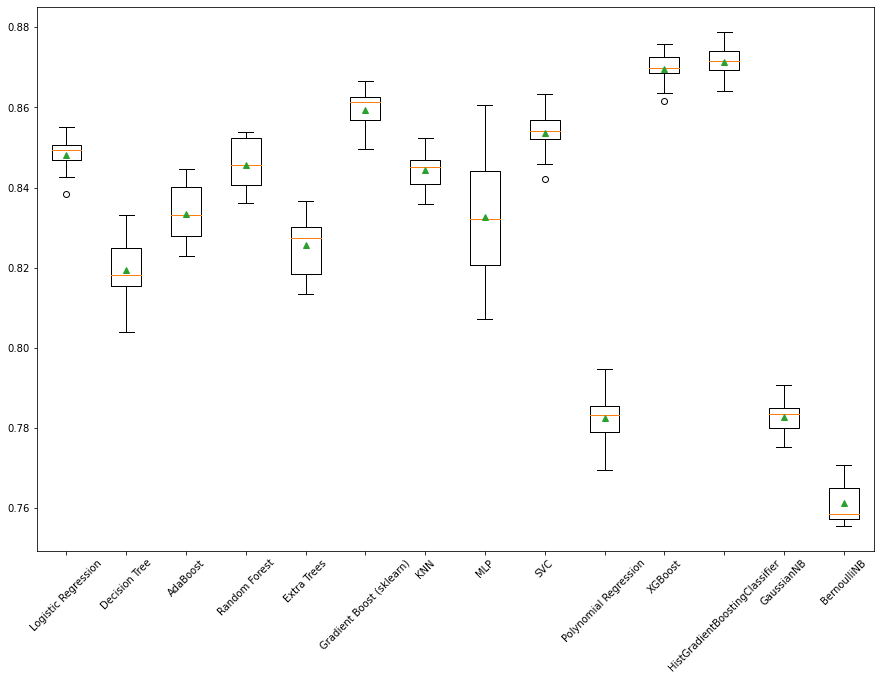

In [517]:
plt.figure(figsize=(15,10))
_ = plt.boxplot(results.values(), labels=results.keys(), showmeans=True)
_ = plt.xticks(rotation = 45)

In [518]:
frame = pd.DataFrame(results).melt()
px.box(frame, x="variable", y = "value")

Xgboost and scikit learn's HistGradientBoostingClassifier are the top two best models. Scikit learn's Gradient boosting also comes in clode 3rd. Support vector classifier also performed very well. As expected gradient boosted trees perform at the top.

In [ ]:
# fit best models (hyperparameters) on all data no cross-validation
for name, model in best_models.items():
    if name == "KNN" or name == "SVC":
        model.fit(X_standard, y)
            
    elif name == "HistGradientBoostingClassifier" or name == 'GaussianNB' or name == 'BernoulliNB':
        model.fit(X_not_standard.toarray(),y)
    
    else:
        model.fit(X_not_standard, y)
        
#Get training metrics for all models
train_results = {}
for name, model in best_models.items():
    if name == "KNN" or name == "SVC":
        pred = model.predict(X_standard)
            
    elif name == "HistGradientBoostingClassifier" or name == 'GaussianNB' or name == 'BernoulliNB':
        pred = model.predict(X_not_standard.toarray())
    
    else:
        pred = model.predict(X_not_standard)

    
    precision = precision_score(y, pred,average='weighted')
    recall = recall_score(y,pred,average='weighted')
    f1 = f1_score(y,pred,average='weighted')
    f1_2 = fbeta_score(y,pred,beta=2,average='weighted')
    acc = accuracy_score(y,pred)
    balanced = balanced_accuracy_score(y,pred)


    train_results[name] = [precision, recall, f1, f1_2, acc, balanced]
    
#Sort by lowest
train_results_sorted = {k: v for k, v in sorted(train_results.items(), key=lambda item: item[1])}


#Get testing metrics for all models
df_test['Income'] = df_test.Income.replace({df_test.Income.unique()[0]: 0, df_test.Income.unique()[1]: 1})
df_test.drop('EducationNum', axis=1, inplace=True)
df_test.drop('Fnlwgt', axis=1, inplace=True)
categorical_cols = df_test.select_dtypes(include=['O']).columns
df_test[categorical_cols] = df_test[categorical_cols].apply(lambda x: x.str.strip())
df_test[df_test == '?'] = np.nan
X_test = df_test.drop('Income', axis=1)
y_test = df_test['Income']

X_test_not_standard = preprocessor.transform(X_test)
X_test_standard = standardized_preprocessor.transform(X_test)
test_results = {}
for name, model in best_models.items():
    if name == "KNN" or name == "SVC":
        pred = model.predict(X_test_standard)
            
    elif name == "HistGradientBoostingClassifier" or name == 'GaussianNB' or name == 'BernoulliNB':
        pred = model.predict(X_test_not_standard.toarray())
    
    else:
        pred = model.predict(X_test_not_standard)

    
    precision = precision_score(y_test, pred,average='weighted')
    recall = recall_score(y_test,pred,average='weighted')
    f1 = f1_score(y_test,pred,average='weighted')
    f1_2 = fbeta_score(y_test,pred,beta=2,average='weighted')
    acc = accuracy_score(y_test,pred)
    balanced = balanced_accuracy_score(y_test,pred)


    test_results[name] = [precision, recall, f1, f1_2, acc, balanced]
    
#Sort by lowest
test_results_sorted = {k: v for k, v in sorted(test_results.items(), key=lambda item: item[1])}

In [539]:
train_df = pd.DataFrame(train_results_sorted.values(),index=train_results_sorted.keys())
train_df.columns = ['Precision','Recall','F1_Score','F2_Score','Accuracy','Balanced Accuracy']
train_df.index.name = 'Model'
train_df.reset_index(inplace=True)

test_df = pd.DataFrame(test_results_sorted.values(),index=test_results_sorted.keys())
test_df.columns = ['Precision','Recall','F1_Score','F2_Score','Accuracy','Balanced Accuracy']
test_df.index.name = 'Model'
test_df.reset_index(inplace=True)

In [540]:
train_df.sort_values(by=['Precision','Recall','F2_Score'],ascending=False)

Model  Precision    Recall  F1_Score  F2_Score  \
11                   Decision Tree   0.976544  0.976414  0.976134  0.976222   
12                        AdaBoost   0.976544  0.976414  0.976134  0.976222   
13                     Extra Trees   0.976544  0.976414  0.976134  0.976222   
10                   Random Forest   0.976187  0.976291  0.976208  0.976250   
9   HistGradientBoostingClassifier   0.879066  0.882774  0.879251  0.880999   
8                          XGBoost   0.875888  0.879826  0.874784  0.877161   
7         Gradient Boost (sklearn)   0.862081  0.866742  0.858812  0.862452   
6                              MLP   0.861120  0.853936  0.856692  0.854827   
5                              SVC   0.859250  0.864715  0.858544  0.861528   
4                              KNN   0.852075  0.857191  0.853382  0.855390   
3              Logistic Regression   0.844584  0.850926  0.845741  0.848416   
2                       GaussianNB   0.839313  0.782255  0.795725  0.783436   
1                      BernoulliNB   0.815877  0.758791  0.773538  0.760860   
0            Polynomial Regression   0.785282  0.799822  0.766082  0.782582   

    Accuracy  Balanced Accuracy  
11  0.976414           0.956513  
12  0.976414           0.956513  
13  0.976414           0.956513  
10  0.976291           0.964139  
9   0.882774           0.813203  
8   0.879826           0.800245  
7   0.866742           0.770381  
6   0.853936           0.821075  
5   0.864715           0.776970  
4   0.857191           0.780897  
3   0.850926           0.766017  
2   0.782255           0.801602  
1   0.758791           0.767252  
0   0.799822           0.624727

In [541]:
test_df.sort_values(by=['Precision','Recall','F2_Score'],ascending=False)

Model  Precision    Recall  F1_Score  F2_Score  \
13                         XGBoost   0.870373  0.875069  0.869873  0.872389   
12  HistGradientBoostingClassifier   0.868242  0.872735  0.869025  0.870929   
11        Gradient Boost (sklearn)   0.862053  0.867146  0.859198  0.862889   
10                             SVC   0.850901  0.857441  0.851148  0.854289   
9                              MLP   0.850105  0.843007  0.845852  0.843968   
8              Logistic Regression   0.844249  0.850808  0.845603  0.848309   
7                       GaussianNB   0.844142  0.785947  0.799673  0.787116   
6                              KNN   0.839109  0.845034  0.840943  0.843147   
5                    Random Forest   0.837860  0.843806  0.839734  0.841933   
4                         AdaBoost   0.830584  0.835514  0.832495  0.834180   
3                      BernoulliNB   0.820483  0.763651  0.778479  0.765791   
2                      Extra Trees   0.818652  0.824642  0.820950  0.823008   
1                    Decision Tree   0.815918  0.818070  0.816928  0.817597   
0            Polynomial Regression   0.781160  0.799091  0.765276  0.782030   

    Accuracy  Balanced Accuracy  
13  0.875069           0.791602  
12  0.872735           0.797797  
11  0.867146           0.768097  
10  0.857441           0.765336  
9   0.843007           0.802311  
8   0.850808           0.762969  
7   0.785947           0.806622  
6   0.845034           0.761613  
5   0.843806           0.760181  
4   0.835514           0.755112  
3   0.763651           0.771463  
2   0.824642           0.737758  
1   0.818070           0.741807  
0   0.799091           0.619382

In [558]:
features = dict(zip(preprocessor.get_feature_names_out(),best_models['XGBoost'].feature_importances_))
features_sorted = dict(sorted(features.items(), key=lambda item: item[1],reverse=True))
x,y = zip(*features_sorted.items())
figure_imp = go.Figure(go.Bar(x= x[:50],y=y[:50]))
figure_imp.update_layout(title = "Feature Importances using XGBoost", width=1500)

In [590]:
def plot_roc(clf, X_test, y_test, figsize=(17, 6)):
    
    try:
        
        y_score = clf.predict_proba(X_test)
    
    except AttributeError as e:
         y_score = clf.decision_function(X_test)
        
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.title('Receiver Operating Characteristic')
    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.grid(alpha=.4)
    ax.legend(loc="best")
    sns.despine()
    plt.show()
    
    
def plot_pr(clf, X_test, y_test ,figsize=(17, 6)):
    
    try:
        
        y_score = clf.predict_proba(X_test)
    
    except AttributeError as e:
         y_score = clf.decision_function(X_test)
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
    pr_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize=figsize)
    plt.title('Precision-Recall Curve')
    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % pr_auc)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.grid(alpha=.4)
    ax.legend(loc="best")
    sns.despine()
    plt.show()

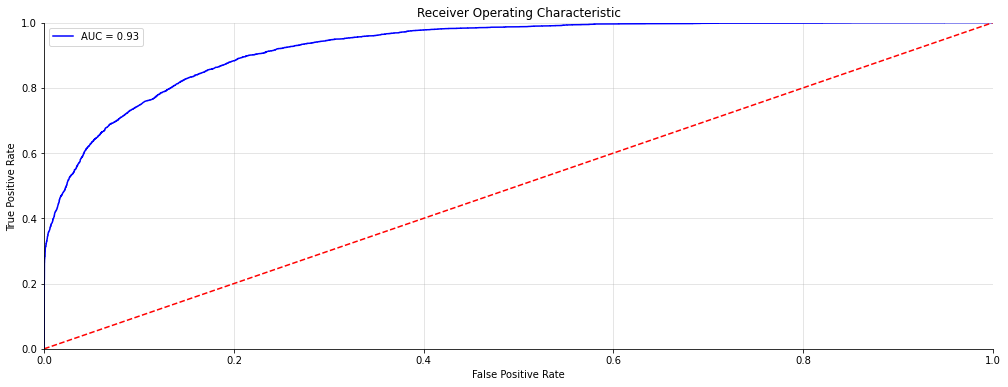

In [591]:
plot_roc(best_models['XGBoost'], X_test_not_standard, y_test)

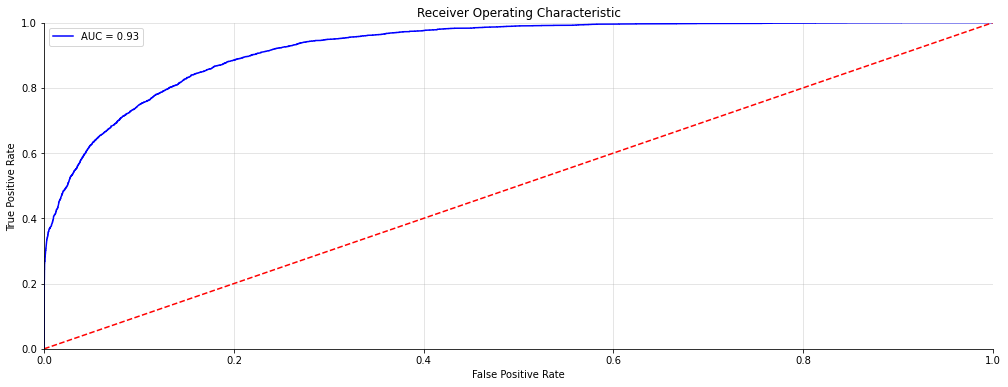

In [593]:
plot_roc(best_models['HistGradientBoostingClassifier'], X_test_not_standard.toarray(), y_test)

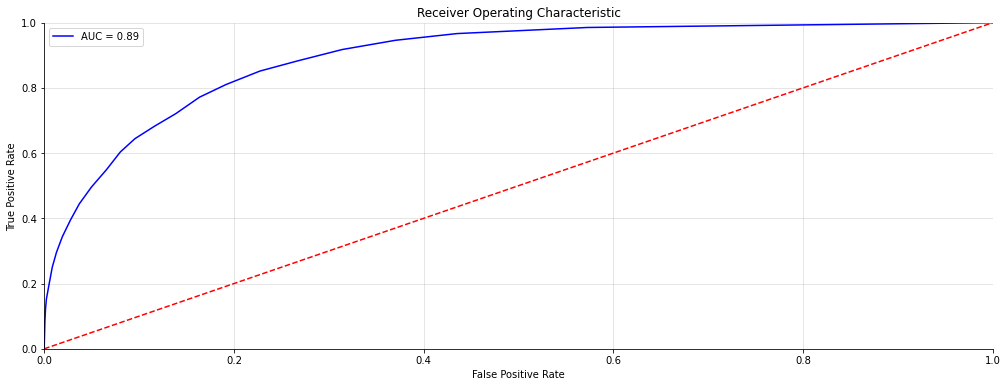

In [598]:
plot_roc(best_models['KNN'], X_test_standard, y_test)

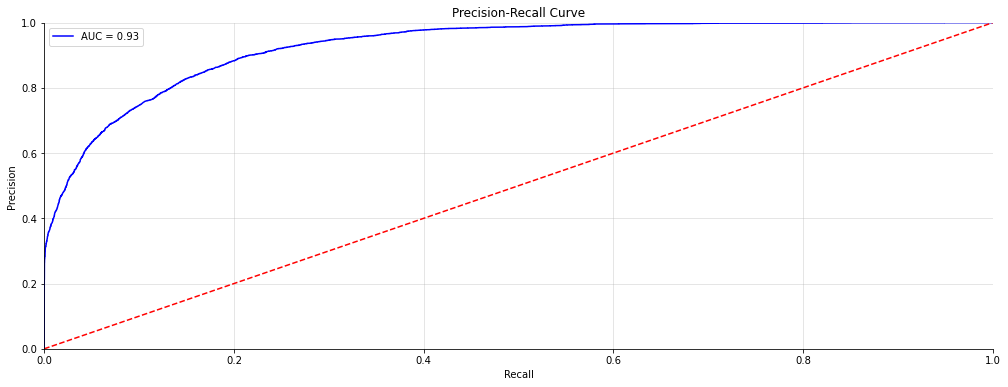

In [599]:
plot_pr(best_models['XGBoost'], X_test_not_standard, y_test)

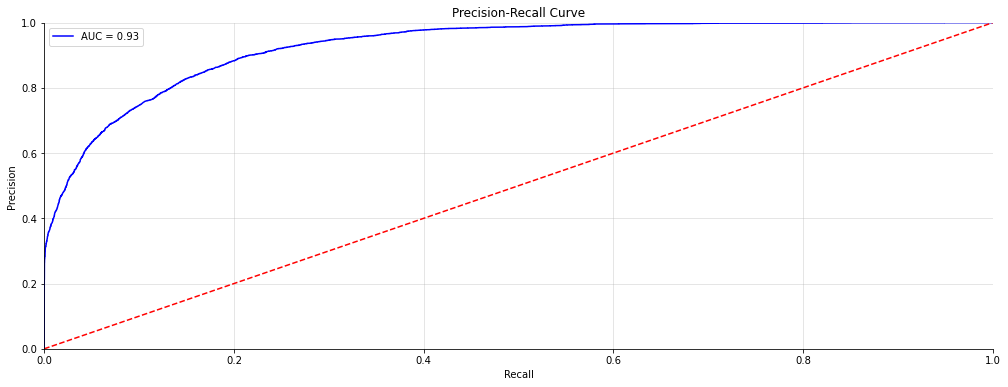

In [600]:
plot_pr(best_models['HistGradientBoostingClassifier'], X_test_not_standard.toarray(), y_test)

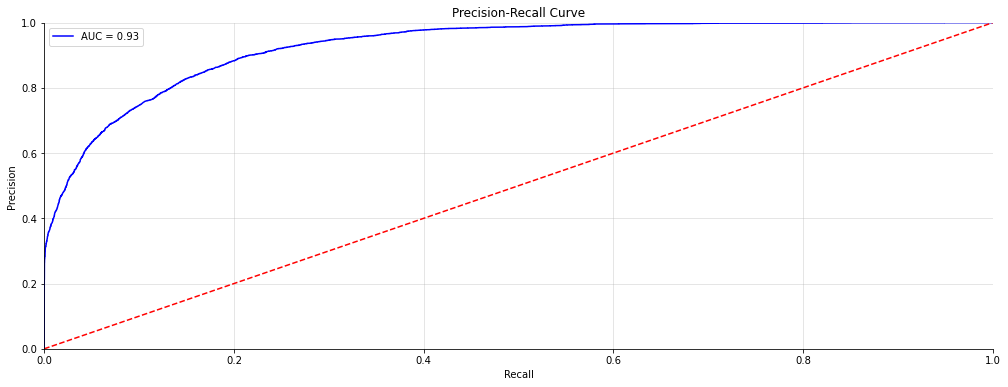

In [601]:
plot_pr(best_models['KNN'], X_test_standard, y_test)

In [602]:
px.bar(test_df, x= "Model", y="F2_Score", barmode='group')

From the above analysis we are simply portraying our conclusion regarding the best models in various visuals, which all confirm our conclusion

#### Error Analysis

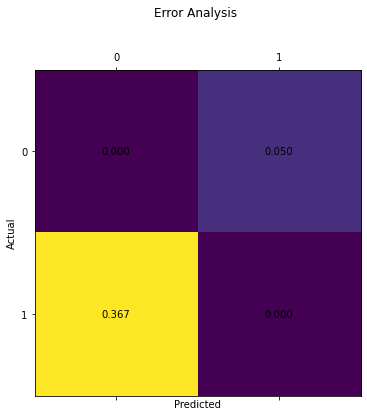

In [603]:
prediction = best_models['XGBoost'].predict(X_test_not_standard)
conf_mx = confusion_matrix(y_test, prediction)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

labels = df_test.Income.unique().tolist()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx,cmap='viridis')


for (i, j), z in np.ndenumerate(norm_conf_mx):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
    
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
plt.title("Error Analysis \n\n")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

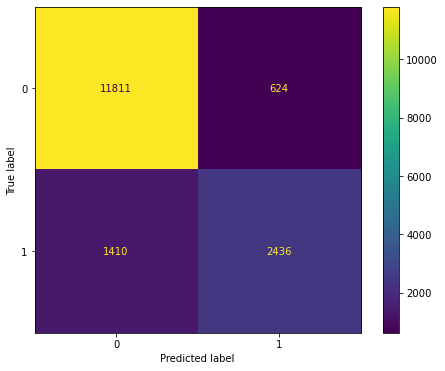

In [604]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
_ = ConfusionMatrixDisplay.from_predictions(y_test,prediction, ax=ax)

In [634]:
display(Markdown(f"The best model (XGboost) mostly misclassifies the positive label (Income >50K), this is mainly due to the fact that it is an unbalanced dataset, but we get very good metrics for this model. It's F-beta(2) score is 0.87, accuracy is 0.875 and AUC of 0.93 both for the receiver operater curve and precision-recall curve.\n \ We'll use it as the final model trained on the whole data with the best parameters, let's save them. \n  \
- N_estimators = {best_models['XGBoost'].n_estimators}\n \
- learning_rate = {best_models['XGBoost'].learning_rate} ~ 0.1\n \
- objective = '{best_models['XGBoost'].objective}'"))

The best model (XGboost) mostly misclassifies the positive label (Income >50K), this is mainly due to the fact that it is an unbalanced dataset, but we get very good metrics for this model. It's F-beta(2) score is 0.87, accuracy is 0.875 and AUC of 0.93 both for the receiver operater curve and precision-recall curve.
 \ We'll use it as the final model trained on the whole data with the best parameters, let's save them. 
  - N_estimators = 100
 - learning_rate = 0.09999999999999999 ~ 0.1
 - objective = 'binary:logistic'